In [1]:
import gym
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2

import numpy as np
from collections import deque, namedtuple
import copy

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

import warnings
warnings.filterwarnings("ignore")

### Environment - BipedalWalker-v3

Please check the [documentation](https://www.gymlibrary.dev/environments/box2d/BipedalWalker/) for details.

In [2]:
env = gym.make('BipedalWalker-v3')
env.seed(0)
print('State shape: ', env.observation_space)
print('Number of actions: ', env.action_space)
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('State size: ', state_size)
print('Action size: ', action_size)
action_range = [-1, -0.5, 0, 0.5, 1]
action_list = [[i, j, k, l] for i in action_range for j in action_range for k in action_range for l in action_range]
print('Action list: ', action_list)


State shape:  Box([-3.1415927 -5.        -5.        -5.        -3.1415927 -5.
 -3.1415927 -5.        -0.        -3.1415927 -5.        -3.1415927
 -5.        -0.        -1.        -1.        -1.        -1.
 -1.        -1.        -1.        -1.        -1.        -1.       ], [3.1415927 5.        5.        5.        3.1415927 5.        3.1415927
 5.        5.        3.1415927 5.        3.1415927 5.        5.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.       ], (24,), float32)
Number of actions:  Box(-1.0, 1.0, (4,), float32)
State size:  24
Action size:  4
Action list:  [[-1, -1, -1, -1], [-1, -1, -1, -0.5], [-1, -1, -1, 0], [-1, -1, -1, 0.5], [-1, -1, -1, 1], [-1, -1, -0.5, -1], [-1, -1, -0.5, -0.5], [-1, -1, -0.5, 0], [-1, -1, -0.5, 0.5], [-1, -1, -0.5, 1], [-1, -1, 0, -1], [-1, -1, 0, -0.5], [-1, -1, 0, 0], [-1, -1, 0, 0.5], [-1, -1, 0, 1], [-1, -1, 0.5, -1], [-1, -1, 0.5, -0.5], [-1, -1, 0.5, 0], [-1, -1, 0.5, 0.5], [-1, -1, 0.5, 1], [-1, -1

In [3]:
# Define MLP policy

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.

        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        # XXX NOTE: Commenting this line to avoid conflict with deepcopy
        # self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, action_size)
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(1024)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.fc5(x)
        return x

### Define some hyperparameter

In [20]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network
CLONE_EVERY = int(1e4)  # how often to clone the q networks

In [5]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

### Define Agent

In [6]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, env):
        """Initialize an Agent object.

        Args:
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.env = env

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def clone(self):
        try:
            del self.qnetwork_target
        except:
            pass

        self.qnetwork_target = copy.deepcopy(self.qnetwork_local)

        for p in self.qnetwork_target.parameters():
            p.requires_grad = False

        self.qnetwork_target = self.qnetwork_target.to(device)

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step += 1

        if self.t_step % UPDATE_EVERY == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

        if self.t_step % CLONE_EVERY == 0:
            self.clone()


    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Args:
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Args:
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states)

        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### Define Replay Buffer

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Args:
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Training Process

In [8]:
def dqn(n_episodes=2000, max_t=1600, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Args:
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            action = action_list[action]
            next_state, reward, done, _= env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # if np.mean(scores_window)>=200.0:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            # break
    return scores

In [21]:
action_size = env.action_space.shape[0]
action_size = len(action_range) ** action_size
print('Action size: ', action_size)
agent = Agent(state_size, action_size, seed=0, env=env)
scores = dqn()

Action size:  625
Episode 100	Average Score: -111.75
Episode 200	Average Score: -108.73
Episode 300	Average Score: -108.44
Episode 400	Average Score: -113.17
Episode 500	Average Score: -115.27
Episode 600	Average Score: -111.01
Episode 700	Average Score: -112.75
Episode 800	Average Score: -108.87
Episode 900	Average Score: -115.37
Episode 1000	Average Score: -117.68
Episode 1100	Average Score: -117.73
Episode 1200	Average Score: -117.67
Episode 1300	Average Score: -109.72
Episode 1400	Average Score: -117.45
Episode 1500	Average Score: -112.22
Episode 1600	Average Score: -110.16
Episode 1700	Average Score: -113.71
Episode 1800	Average Score: -109.17
Episode 1900	Average Score: -111.60
Episode 2000	Average Score: -115.33


### Plot the learning progress

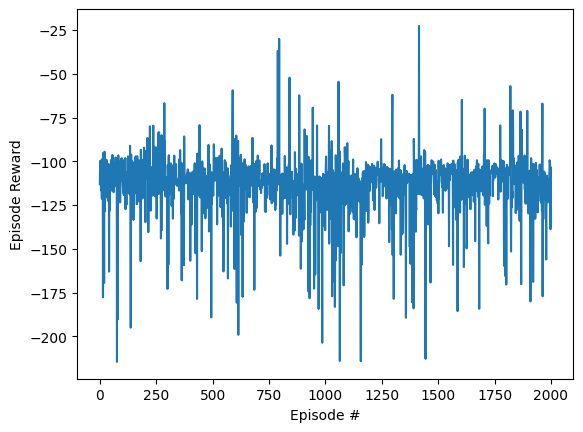

In [22]:
# plot the scores
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Episode Reward')
plt.xlabel('Episode #')
plt.show()

### Bonus

In [23]:
def eval(agent, num_episodes):
    total_rewards = []

    for _ in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state) 
            action = action_list[action] 
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    average_reward = np.mean(total_rewards)
    return average_reward

In [24]:
average_reward = eval(agent, 100)
print('Average reward: ', average_reward)

Average reward:  -103.32295363689694
